# Perceptron - Prédiction chat vs chien
## Description
On souhaite créer un réseau de neurone qui soit capable de distinguer un chat d'un chien sur une image en noir et blanc. Pour cela, on dispose de :
- Un dataset d'entraînement de 1000 images
- Un dataset de test de 200 images

Chaque image est composée de 64x64 pixels.

Ici on utilise le neurone à une seule couche afin de voir les limitations de ce modèle sur un jeu de donnée réel. **Pour plus de détails sur ce modèle, cf. Notebook précédent**

L'application de ce perceptron est volontairement "trop" complexe.

## Objectif
1. Observer les limitations d'un perceptron sur un dataset réel
***

## 1ère partie - Création du perceptron

#### Chargement des données nécessaires et affichage

In [1]:
from utilities import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [2]:
X_train, y_train, X_test, y_test = load_data()

On affiche les dimensions du dataset d'entraînement.

In [3]:
print(X_train.shape)
print(y_train.shape)

(1000, 64, 64)
(1000, 1)


On affiche quelques images du dataset en leur donnant pour titre la catégorie dans laquelle ils sont :
- 1 pour les chiens
- 0 pour les chats


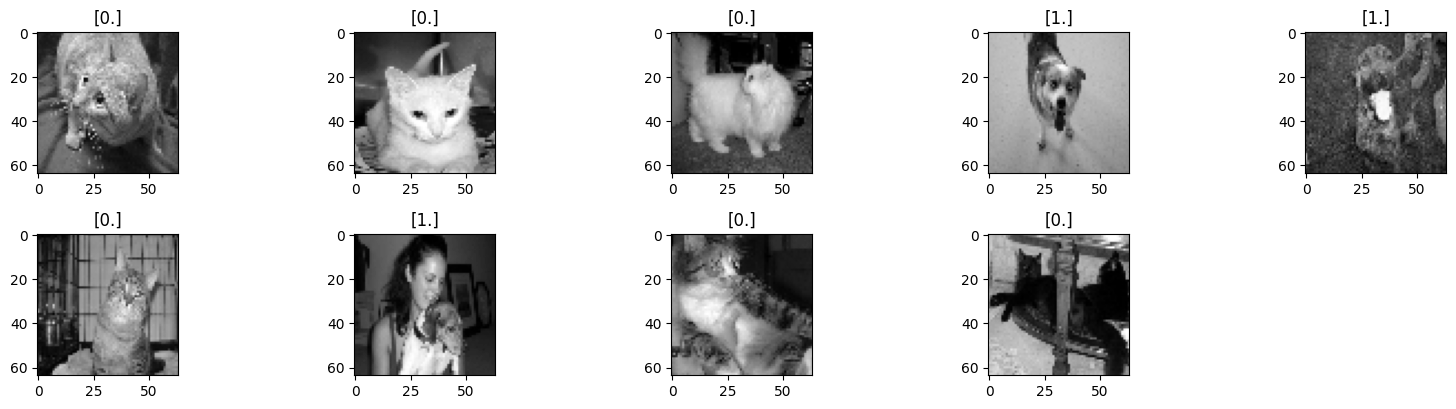

In [4]:
plt.figure(figsize = (16, 8))
for i in range(1, 10):
    plt.subplot(4, 5, i)
    plt.imshow(X_train[i], cmap = 'gray')
    plt.title(y_train[i])
    plt.tight_layout()

plt.show()

In [30]:
prop_chiens_test = sum(y_test == 1)/len(y_test)
prop_chiens_train = sum(y_train == 1)/len(y_train)

print(f'Proportion de chiens dans le testset : {prop_chiens_test}')
print(f'Proportion de chiens dans le traintset : {prop_chiens_train}')

Proportion de chiens dans le testset : [0.5]
Proportion de chiens dans le traintset : [0.5]


#### Mise en forme des données

On normalise les données pour éviter les overflows sur l'exponentielle causés par la fonction d'activation (cf. fonction <code>model</code>).

On applique une normalisation min/max : $X = \frac{X - X_{min}}{X_{max} - X_{min}}$.

Ici $X_{min} = 0$ donc il suffit de diviser par le maximum.

In [5]:
X_maximum_train = X_train.max()
print('Maximum de X_train avant normalisation :', X_train.max())
X_train = X_train / X_train.max()
print('Maximum de X_train après normalisation :', X_train.max())

Maximum de X_train avant normalisation : 254
Maximum de X_train après normalisation : 1.0


In [6]:
print('Maximum de X_test avant normalisation :', X_test.max())
X_test = X_test / X_maximum_train
print('Maximum de X_test après normalisation :', X_test.max())

Maximum de X_test avant normalisation : 254
Maximum de X_test après normalisation : 1.0


Une fois normalisées, on redimensionne les données pour qu'une image de 64x64 pixels devienne un vecteur de taille 1x4096

In [7]:
X_train_flat = np.array([X_train[i].flatten() for i in range(X_train.shape[0])])
X_test_flat = np.array([X_test[i].flatten() for i in range(X_test.shape[0])])

print('Dimensions des données d\'entraînement :', X_train_flat.shape)
print('Dimensions des données de test :', X_test_flat.shape)

Dimensions des données d'entraînement : (1000, 4096)
Dimensions des données de test : (200, 4096)


#### Création du modèle

Création de la fonction d'initialisation, on choisis des nombres au hasard.

In [8]:
def init(x):
    return (np.random.rand(x.shape[1], 1), np.random.randn(1))

Fonction d'activation. On rajoute un offset pour éviter l'overflow de l'exponentielle.

In [9]:
def model(x, w, b, offset = 1e-10):
    z = x.dot(w) + b
    a_z = 1 / (1 + np.exp(-z + offset))
    return a_z

Fonction log_loss. On utilise celle de sklearn qui inclut un epsilon dans le log

In [10]:
from sklearn.metrics import log_loss

In [11]:
# def log_loss(a, y):
#    return 1/len(y) * np.sum(-(1-y) * np.log(1-a) - y * np.log(a))

Gradients de notre modèle

In [12]:
def gradient(x, a, y):

    dw = (1 / len(y)) * np.dot(x.T, a - y)
    db = (1 / len(y)) * np.sum(a - y)
    
    return (dw, db)

In [13]:
def update_neurone(w, b, dw, db, alpha):
    new_w = w - alpha * dw
    new_b = b - alpha * db

    return (new_w, new_b)

Fonction de prédiction. Si on est au-dessus de 0.5, on renvoie True (= 1 = chein), sinon False (= 0 = chat)

In [14]:
def predict(x, w, b):
    a = model(x, w, b)
    return a >= 0.5

Création du neurone à une couche

In [15]:
def artificial_neuron(X_train, y_train, X_test, y_test, learning_rate = 0.1, n_iter = 100):
    w, b = init(X_train)

    loss_train = []
    acc_train = []
    
    loss_test = []
    acc_test = []
    
    for i in tqdm(range(n_iter)):
        a = model(X_train, w, b)

        if i % 10 == 0 :
            loss_train.append(log_loss(y_train, a))
            y_pred = predict(X_train, w, b)
            acc_train.append(accuracy_score(y_train, y_pred))

            # Test
            a_test = model(X_test, w, b)
            loss_test.append(log_loss(y_test, a_test))
            y_pred = predict(X_test, w, b)
            acc_test.append(accuracy_score(y_test, y_pred))
            
        dw, db = gradient(X_train, a, y_train)
        w, b = update_neurone(w, b, dw, db, learning_rate)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(loss_train, label = 'train loss')
    plt.plot(loss_test, label = 'test loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(acc_train, label = 'train accuracy')
    plt.plot(acc_test, label = 'test accuracy')

    plt.legend()
    plt.show()
    return (w, b)

## Application du modèle

<font color='red'>Dans les graphiques on n'affiche que 10% des itérations pour ne pas augmenter les temps de calcul</font>

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 249.54it/s]


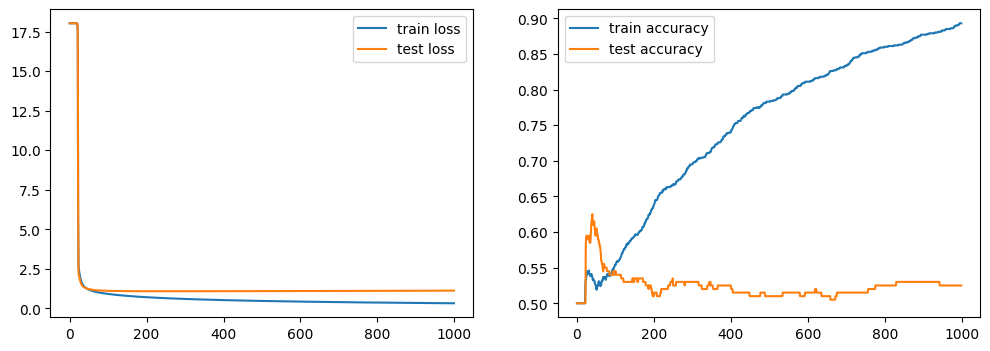

In [16]:
w, b = artificial_neuron(X_train_flat, y_train, X_test_flat, y_test, learning_rate = 0.01, n_iter = 10000)

In [17]:
y_pred_test = predict(X_test_flat, w, b)
accuracy_score(y_pred_test, y_test)

0.525

Le modèle est clairement en sur-apprentissage (accuracy qui augmente sur le train set et qui stagne sur le test set), la train accuracy continue d'augmenter quand la test accuracy plafonne. On essaie plusieurs autres hyperparamètres pour voir si l'on peut faire converger un peu plus le modèle.

### Modifications des hyperparamètres

#### Modification du learning rate

- $\alpha = 1$

 20%|███████████████▌                                                            | 2048/10000 [00:08<00:32, 248.09it/s]C:\Users\jessi\AppData\Local\Temp\ipykernel_7460\539630268.py:3: RuntimeWarning: overflow encountered in exp
  a_z = 1 / (1 + np.exp(-z + offset))
 21%|███████████████▊                                                            | 2073/10000 [00:08<00:32, 241.35it/s]C:\Users\jessi\AppData\Local\Temp\ipykernel_7460\539630268.py:3: RuntimeWarning: overflow encountered in exp
  a_z = 1 / (1 + np.exp(-z + offset))
C:\Users\jessi\AppData\Local\Temp\ipykernel_7460\539630268.py:3: RuntimeWarning: overflow encountered in exp
  a_z = 1 / (1 + np.exp(-z + offset))
 21%|███████████████▉                                                            | 2099/10000 [00:08<00:32, 241.21it/s]C:\Users\jessi\AppData\Local\Temp\ipykernel_7460\539630268.py:3: RuntimeWarning: overflow encountered in exp
  a_z = 1 / (1 + np.exp(-z + offset))
C:\Users\jessi\AppData\Local\Temp\ipykernel_7460\539630

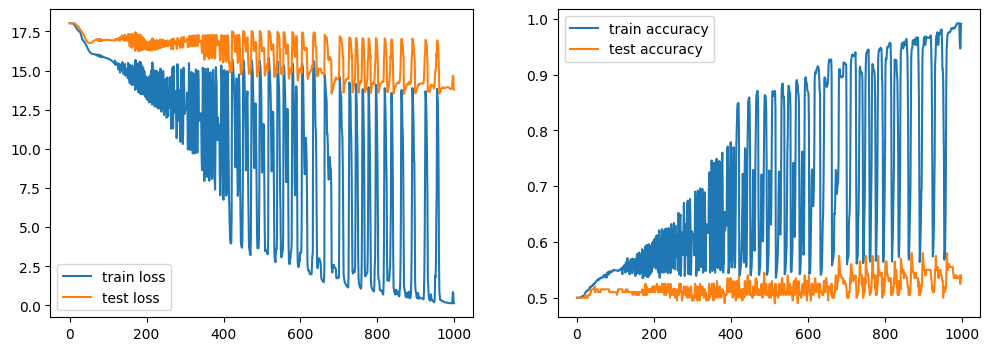

In [18]:
w, b = artificial_neuron(X_train_flat, y_train, X_test_flat, y_test, learning_rate = 1, n_iter = 10000)

Instabilité du modèle, le gradient n'arrive plus à converger. Il y a beaucoup d'erreur d'overflow malgré l'offset, ça ne doit pas aider à converger.

- $\alpha = 0.05$

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 241.09it/s]


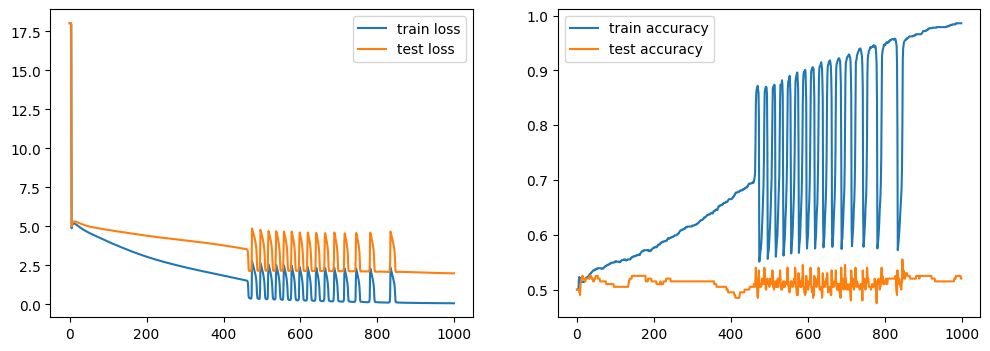

In [19]:
w, b = artificial_neuron(X_train_flat, y_train, X_test_flat, y_test, learning_rate = 0.05, n_iter = 10000)

Encore beaucoup d'instabilité et toujours en sur-apprentissage

- $\alpha = 0.005$

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 246.80it/s]


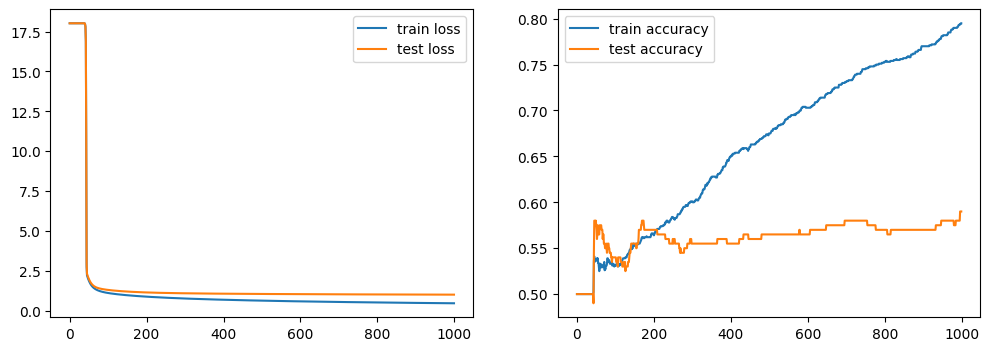

In [20]:
w, b = artificial_neuron(X_train_flat, y_train, X_test_flat, y_test, learning_rate = 0.005, n_iter = 10000)

On augment un peu l'accuracy mais on est toujours en sur-apprentissage. On essaie de diminuer encore le learning rate.

- $\alpha = 0.05$

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 244.68it/s]


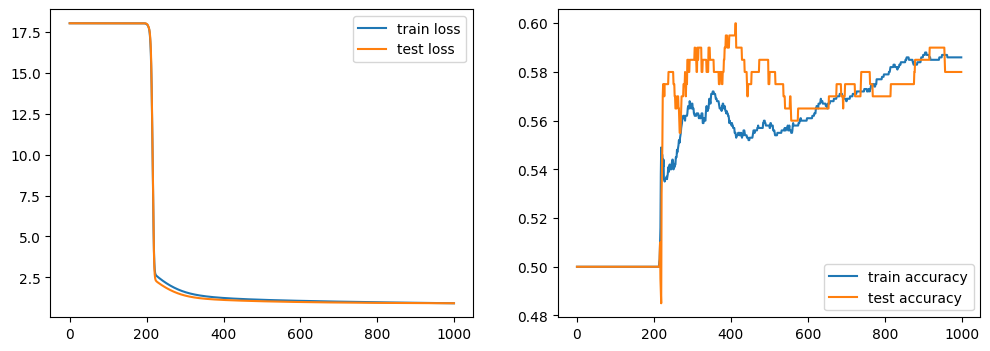

In [21]:
w, b = artificial_neuron(X_train_flat, y_train, X_test_flat, y_test, learning_rate = 0.001, n_iter = 10000)

Le modèle n'est plus en sur-apprentissage par contre l'accuracy est faible. On essaie d'augmenter le nombre d'itérations. On le multiplie par 2 dans un premier temps.

- $\alpha = 0.001$
- $n = 20000$

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:22<00:00, 241.12it/s]


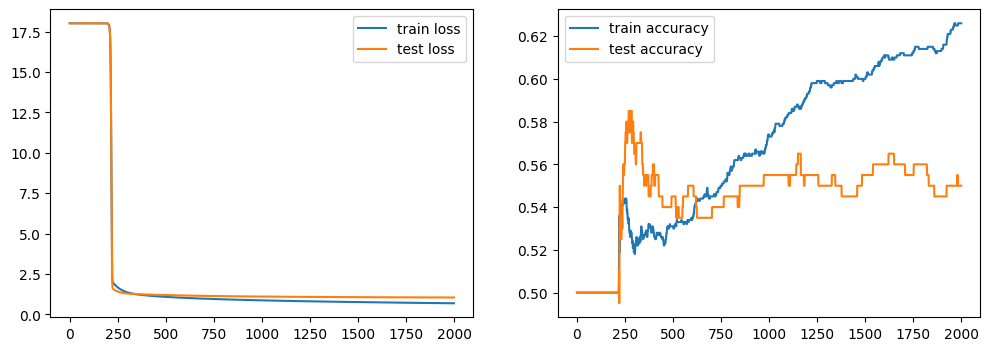

In [22]:
w, b = artificial_neuron(X_train_flat, y_train, X_test_flat, y_test, learning_rate = 0.001, n_iter = 20000)

C'est inefficace, on rentre à nouveau en sur-apprentissage. On revient à 10k itérations mais on diminue à nouveau le learning rate.

- $\alpha = 0.0005$
- $n = 10000$

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:40<00:00, 245.76it/s]


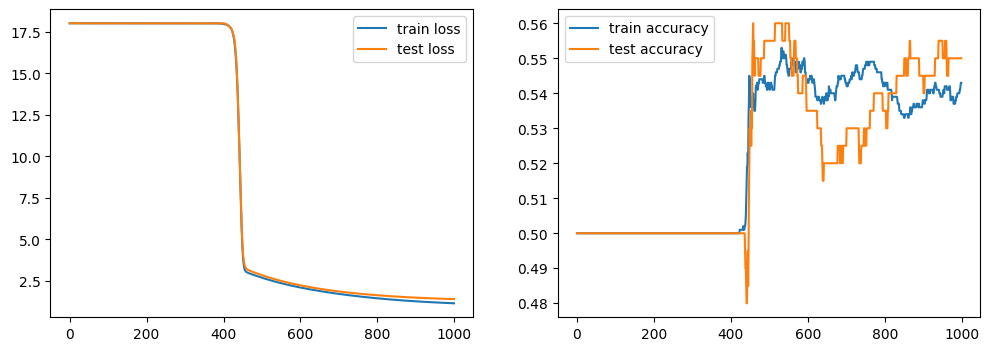

In [32]:
w, b = artificial_neuron(X_train_flat, y_train, X_test_flat, y_test, learning_rate = 0.0005, n_iter = 10000)

Toujours aussi peu concluant...

- $\alpha = 0.000 1$
- $n = 10000$

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 239.28it/s]


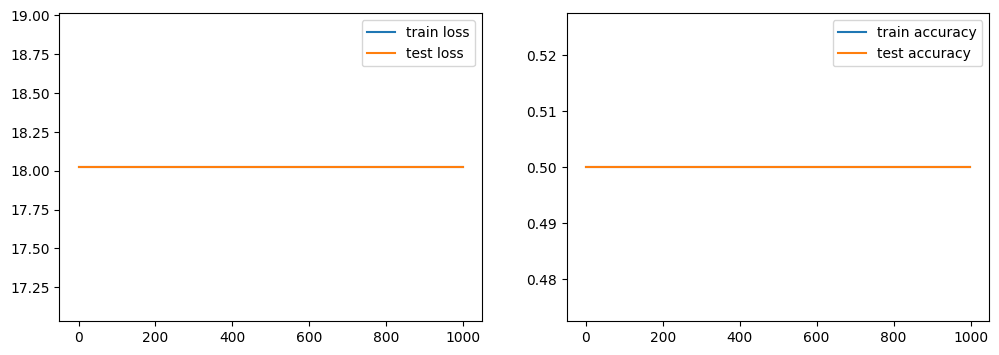

In [33]:
w, b = artificial_neuron(X_train_flat, y_train, X_test_flat, y_test, learning_rate = 0.0001, n_iter = 10000)

Le modèle n'apprend plus.

Conclusion : Le modèle est trop simpliste pour notre problématique de reconnaissance d'image. Peut-être qu'un réseau de neurone à plusieurs couches serait plus adapté.